This notebook illustrates how to apply the transformer metric to a single burst time series. We load all the data into memory.

TODO: make the data loading more efficient!

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rasterio.plot import show
from scipy.special import expit, logit

from distmetrics import (
    compute_mahalonobis_dist_2d,
    compute_transformer_zscore,
    despeckle_rtc_arrs_with_tv,
    get_asf_rtc_burst_ts,
    load_transformer_model,
    read_asf_rtc_image_data,
)

References:

- CNN story: https://www.cnn.com/2024/05/25/world/video/damage-papua-new-guinea-landslide-ldn-digvid
- ASF Search: https://search.asf.alaska.edu/#/?polygon=POINT(143.3641%20-5.3821)&zoom=13.000&center=143.364,-5.425&resultsLoaded=true&granule=OPERA_L2_RTC-S1_T009-019294-IW2_20240603T084748Z_20240603T133726Z_S1A_30_v1.0&maxResults=250&dataset=OPERA-S1&productTypes=RTC

# Parameters

In [110]:
# Papau New Guinea Landslide
BURST_ID = "T009_019294_IW2"
EVENT_TS = pd.Timestamp("2024-05-28", tz="utc")

# Los Angeles Angeles Fire - Pacific Palisades Burst
BURST_ID = 'T071-151228-IW3'
EVENT_TS = pd.Timestamp("2025-01-08", tz="utc")

LOOKBACK_STRATEGY = 'multi_window'

N_PRE_IMAGES = 10
APPLY_LOGIT = True

N_PRE_IMGS_PER_YEAR = 3

# Download Data

In [69]:
df_rtc_ts = get_asf_rtc_burst_ts(BURST_ID)
print("# of results: ", df_rtc_ts.shape[0])
df_rtc_ts.head()

# of results:  108


,opera_id,acq_datetime,polarization,track_number,geometry,url_vh,url_vv,dedup_id
0,OPERA_L2_RTC-S1_T071-151228-IW3_20220101T13524...,2022-01-01 13:52:49+00:00,VV+VH,71,"POLYGON ((-118.23332 34.15997, -119.11344 34.2...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T071-151228-IW3_20220101T135249Z
1,OPERA_L2_RTC-S1_T071-151228-IW3_20220113T13524...,2022-01-13 13:52:49+00:00,VV+VH,71,"POLYGON ((-118.2332 34.15999, -119.11332 34.28...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T071-151228-IW3_20220113T135249Z
2,OPERA_L2_RTC-S1_T071-151228-IW3_20220125T13524...,2022-01-25 13:52:48+00:00,VV+VH,71,"POLYGON ((-118.23255 34.16051, -119.11264 34.2...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T071-151228-IW3_20220125T135248Z
3,OPERA_L2_RTC-S1_T071-151228-IW3_20220206T13524...,2022-02-06 13:52:48+00:00,VV+VH,71,"POLYGON ((-118.23289 34.15986, -119.11299 34.2...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T071-151228-IW3_20220206T135248Z
4,OPERA_L2_RTC-S1_T071-151228-IW3_20220218T13524...,2022-02-18 13:52:48+00:00,VV+VH,71,"POLYGON ((-118.23419 34.16046, -119.11426 34.2...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T071-151228-IW3_20220218T135248Z


**Warning**: sometime this cell fails and must be re-run due to a transient server error.

In [70]:
arrs_vv, profiles = read_asf_rtc_image_data(df_rtc_ts.url_vv.tolist())
arrs_vh, _ = read_asf_rtc_image_data(df_rtc_ts.url_vh.tolist())

Loading RTC data: 100%|█████| 108/108 [01:17<00:00,  1.39it/s]


In [92]:
arrs_vv_d = despeckle_rtc_arrs_with_tv(arrs_vv, n_jobs=10, interp_method='bilinear')
arrs_vh_d = despeckle_rtc_arrs_with_tv(arrs_vh, n_jobs=10, interp_method='bilinear')

Despeckling: 100%|██████████| 108/108 [00:40<00:00,  2.63it/s]


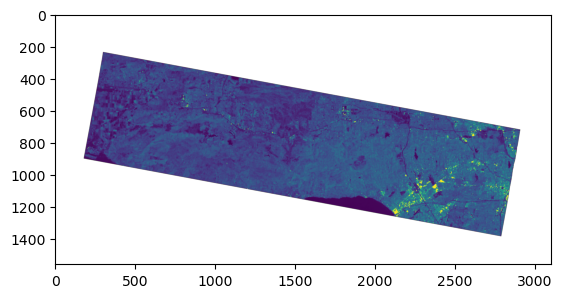

In [93]:
plt.imshow(arrs_vh_d[0], vmin=0, vmax=.15)

In [111]:
def get_anniversary_indices(timestamps: list[pd.Timestamp], event_time: pd.Timestamp, n_imgs_per_year=N_PRE_IMGS_PER_YEAR) -> list[int]:
    ts_series = pd.Series(timestamps)
    base_anniv = event_time - pd.Timedelta(days=365)
    years = sorted(set(ts.year for ts in timestamps if ts.year < event_time.year))
    result = []

    for y in years:
        anniv = base_anniv.replace(year=y)
        candidates = ts_series[ts_series < anniv]
        if not candidates.empty:
            closest = (candidates - anniv).abs().nsmallest(n_imgs_per_year)
            result.extend(closest.index.tolist())

    return sorted(result)


In [112]:
acq_dts = df_rtc_ts.acq_datetime.tolist()
post_index = [
        k for (k, date) in enumerate(acq_dts) if date >= EVENT_TS
    ][0]
post_date = acq_dts[post_index]
post_date, EVENT_TS

(Timestamp('2025-01-09 13:52:54+0000', tz='UTC'),
 Timestamp('2025-01-08 00:00:00+0000', tz='UTC'))

In [113]:
if LOOKBACK_STRATEGY == 'immediate':
    pre_indices = [
        k for (k, date) in enumerate(acq_dts) if date < EVENT_TS
    ][-N_PRE_IMAGES:]
    
elif LOOKBACK_STRATEGY == 'multi_window':
    # Going t
    pre_indices = get_anniversary_indices(acq_dts, post_date)
else:
    raise NotImplementedError('needs to be immediate or multi_window')
    

pre_indices, post_index

([0, 29, 30, 31, 59, 60, 61], 92)

In [114]:
pre_dates = [acq_dts[k] for k in pre_indices]
pre_dates

[Timestamp('2022-01-01 13:52:49+0000', tz='UTC'),
 Timestamp('2022-12-15 13:52:56+0000', tz='UTC'),
 Timestamp('2022-12-27 13:52:55+0000', tz='UTC'),
 Timestamp('2023-01-08 13:52:55+0000', tz='UTC'),
 Timestamp('2023-12-10 13:53:01+0000', tz='UTC'),
 Timestamp('2023-12-22 13:53:00+0000', tz='UTC'),
 Timestamp('2024-01-03 13:53:00+0000', tz='UTC')]

In [115]:
from distmetrics.model_load import ALLOWED_MODELS
ALLOWED_MODELS

['transformer_original',
 'transformer_optimized',
 'transformer_optimized_fine',
 'transformer_anniversary_trained']

In [127]:
transformer = load_transformer_model(lib_model_token='transformer_optimized')

In [128]:
pre_imgs_vv = [arrs_vv_d[k] for k in pre_indices]
pre_imgs_vh = [arrs_vh_d[k] for k in pre_indices]
if APPLY_LOGIT:
    pre_imgs_vv = list(map(logit, pre_imgs_vv))
    pre_imgs_vh = list(map(logit, pre_imgs_vh))

In [129]:
post_vv = arrs_vv_d[post_index]
post_vh = arrs_vh_d[post_index]
if APPLY_LOGIT:
    post_vv = logit(post_vv)
    post_vh = logit(post_vh)

In [130]:
# Landslide
if BURST_ID == "T009_019294_IW2":
    sy = np.s_[1250:1500]
    sx = np.s_[400:750]
    pre_vv_c = [arr[sy, sx] for arr in pre_imgs_vv]
    pre_vh_c = [arr[sy, sx] for arr in pre_imgs_vh]

    post_vv_c = post_vv[sy, sx]
    post_vh_c = post_vh[sy, sx]

else:

    pre_vv_c = [arr for arr in pre_imgs_vv]
    pre_vh_c = [arr for arr in pre_imgs_vh]

    post_vv_c = post_vv
    post_vh_c = post_vh

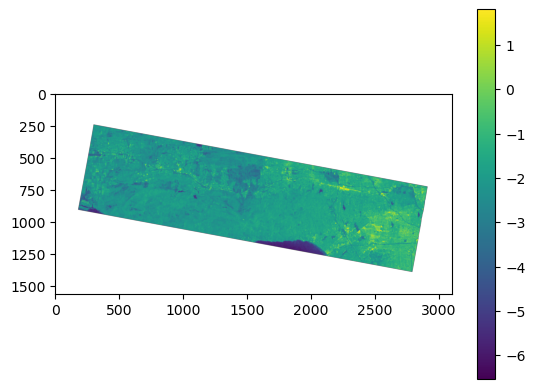

In [131]:
plt.imshow(pre_vv_c[2])
plt.colorbar()

In [132]:
dist_ob = compute_transformer_zscore(
    transformer,
    pre_vv_c,
    pre_vh_c,
    post_vv_c,
    post_vh_c,
    stride=2,
    agg="max",
    batch_size=256,
    memory_strategy="high",
)

Chips Traversed:   0%|               | 0/4660 [00:00<?, ?it/s]

/Users/cmarshak/bekaert-team/distmetrics/src/distmetrics/tf_metric.py:76: UserWarning: A custom validator is returning a value other than `self`.
Returning anything other than `self` from a top level model validator isn't supported when validating via `__init__`.
See the `model_validator` docs (https://docs.pydantic.dev/latest/concepts/validators/#model-validators) for more details.
  m_dist = DiagMahalanobisDistance2d(dist=z_score, mean=mu, std=sigma)


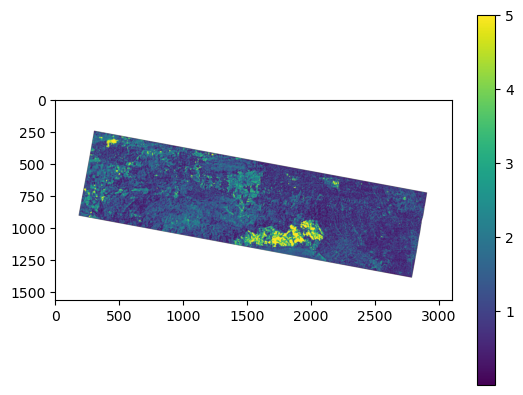

In [133]:
plt.imshow(dist_ob.dist, vmax=5)
plt.colorbar()

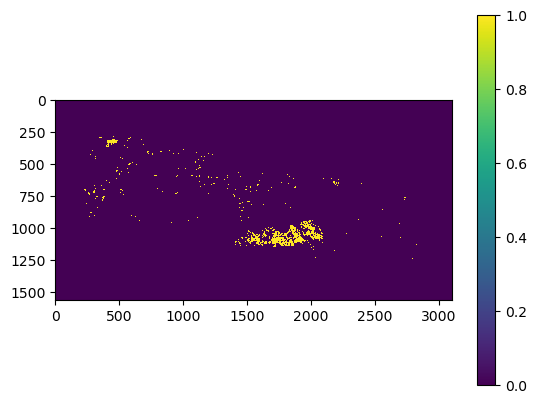

In [137]:
plt.imshow(dist_ob.dist > 3.5, vmax=1, interpolation="none")
plt.colorbar()

**Warninig**: the stat outputs of the function above are in `logits` NOT `gamma naught`. Hence `expit`!

<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\g'
/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_57230/3498562707.py:3: SyntaxWarning: invalid escape sequence '\g'
  plt.title("Mean Estimate VV ($\gamma$)")


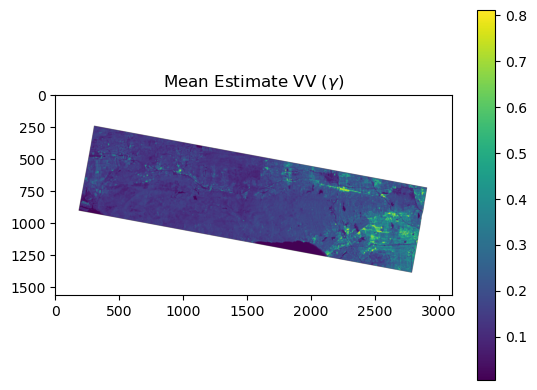

In [138]:
from scipy.special import expit

plt.title("Mean Estimate VV ($\gamma$)")
plt.imshow(expit(dist_ob.mean[0, ...]))
plt.colorbar()

Can't really apply `expit` to `sigma`...

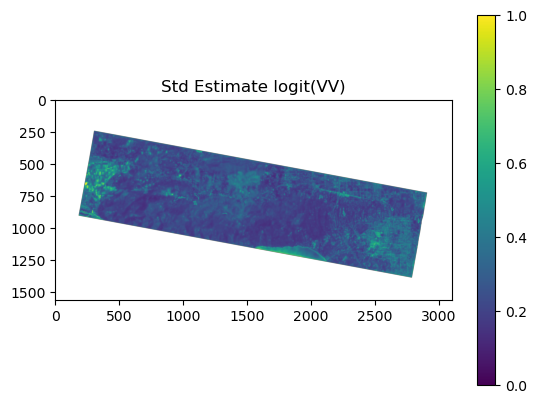

In [139]:
plt.title("Std Estimate logit(VV)")
plt.imshow(dist_ob.std[0, ...], vmax=1, vmin=0)
plt.colorbar()